This notebook runs a Nadaraya-Watson regression on 22687 S82 quasars at a range of kernel widths and scores the performance for each width using the NWscore function in cell 2.  Plots at the bottom show how the score changes with the width of the kernel.  I've tested for widths up to 20, the lowest width for which there are 0 NaNs returned in the prediction. We then find the kernel width that minimizes the median offset of our prediction and run the NW again, this time decreasing the width from 20 to that minimizing width.  We then report the prediction of the lowest kernel width that does not return a NaN for that object.  

In [1]:
import numpy as np
from astropy.table import Table
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from astroML.linear_model import NadarayaWatson
from dask import compute, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import palettable
import richardsplot as rplot
%matplotlib inline
from astropy.stats import median_absolute_deviation

In [2]:
def sklearnScore(yreal, ypred):
    #takes two 1-D arrays of equal length and computes the coefficient of determination R^2
    #mimics the score method of scikit-learn regressors
    yreal_sum = 0
    #a quick loop to calculate the mean of yreal
    for i in range(len(yreal)):
        if not (np.isnan(yreal[i])):
            yreal_sum+=yreal[i]
    yreal_mean = yreal_sum/len(yreal)
    u = 0
    v= 0
    for i in range(len(yreal)):
        if not (np.isnan(ypred[i])):
            uadd = ((yreal[i] - ypred[i])**2)
            vadd = ((yreal[i] - yreal_mean)**2)
            u += uadd
            v += vadd
    score = 1-(u/v)
    return score

In [3]:
def NWscore(yreal, ypred):
    #Takes two 1-D arrays of equal length and computes the distance between their elements
    #returns their median of the distance, median absolute deviation of distance
    #and the number of NaNs in the second array
    diff = []
    nans = 0
    for i in range(len(ypred)):
        if not np.isnan(ypred[i]):
            diff = np.append(diff, abs(yreal[i]-ypred[i]))
        else:
            nans+=1
    return np.median(diff), median_absolute_deviation(diff), nans, sklearnScore(yreal,ypred)

In [4]:
#a generic example of how NWscore works with random sample data and some testing of sklearnScore
ypred = np.random.random_sample(100)
yreal = np.random.random_sample(100)
print NWscore(yreal,ypred)
print sklearnScore(yreal,ypred)
print sklearnScore([1,2,3],[1,2,3])
print sklearnScore([1,2,3],[2,2,2])

(0.3246308495188007, 0.1652842801219534, 0, -1.0353220035289152)
-1.0353220035289152
1
0


In [5]:
#read in S82 quasar table
data = Table.read('s82-GTR-ADM-QSO-master-sweeps-Feb5-2016.fits')
print data.keys()

['RA', 'DEC', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'OBJC_TYPE', 'OBJC_FLAGS', 'OBJC_FLAGS2', 'ROWC', 'COLC', 'FLAGS', 'FLAGS2', 'PSF_FWHM', 'EXTINCTION', 'PSFFLUX', 'PSFFLUX_IVAR', 'CALIB_STATUS', 'RESOLVE_STATUS', 'PSFFLUX_CLEAN', 'PSFFLUX_CLEAN_IVAR', 'PSF_CLEAN_NUSE', 'ZBEST', 'SOURCEBIT', 'SDSS_UFLG', 'AGES_QSO', 'AGES_CODE06', 'KDE_ZPHOTLO', 'KDE_ZPHOTHI', 'KDE_ZPHOTPROB', 'KDE_LOWZORUVX', 'XDQSOZ_PEAKPROB', 'XDQSOZ_PEAKFWHM', 'XDQSOZ_NPEAKS', 'YAPERMAG3', 'JAPERMAG3', 'HAPERMAG3', 'KSAPERMAG3', 'YAPERMAG3ERR', 'JAPERMAG3ERR', 'HAPERMAG3ERR', 'KSAPERMAG3ERR', 'ZPHOTMINJHK', 'ZPHOTBESTJHK', 'ZPHOTMAXJHK', 'ZPHOTPROBJHK', 'R15_CLASS', 'R15_ZPHOT', 'R15_ZPHOTPROB2', 'P15_CLASSSDSS', 'P15_CLASSBOSS', 'P15_QSO_PROB_MAX_BIN', 'P15_ADDED_PHOTOZ_PDF_MAX_BIN', 'ZSPEC']


In [7]:
#this function gets used later to conserve memory resources when making a prediction with Nadaraya-Watson
#essentially we're putting the model.predict method into a function so that dask can conserve memory when doing it
#IMPORTANT:  Using this requires "model" to be defined on the top level
def process(Xin):
    return model.predict(Xin)



In [8]:
#A function that collects data, runs the NW regression, and returns the NWscore for it.  
#Takes:  model: which should be the NadarayaWatson regressor
#        data:  a data table that contains the data you want to train on
#        returnScore: 
def testingfunc(model, data, returnScore = True):
    #X will be the fluxes in ugriz bands, y will be the zspecs
    X = np.vstack([ data['PSFFLUX'].T[0], data['PSFFLUX'].T[1], data['PSFFLUX'].T[2], data['PSFFLUX'].T[3], data['PSFFLUX'].T[4] ]).T
    y = np.array(data['ZSPEC'])
    #split into training and test sets of sizes 4/5 and 1/5 respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=43)
    #import dask, which we are using to conserve memory when running NW on large datasets
    import dask.threaded
    #model = NadarayaWatson('gaussian', width)
    #fit the model to our training set
    model.fit(X_train, y_train)
    #dask code to handle the prediction for the X_test data in a memory-conservative way
    dobjs = [delayed(process)(x.reshape(1,-1)) for x in X_test]
    ypredselfNW1 = compute(*dobjs, get=dask.threaded.get)
    #reshape the dask output to get it back in the form we want
    ypredselfNW1 = np.array(ypredselfNW1).reshape(1,-1)[0]
    #return score for prediction
    if returnScore:
        return NWscore(y_test,ypredselfNW1)
    else:
        return ypredselfNW1, y_test

In [9]:
#initialize arrays for plotting
MedianDiffs = []
MedianDevia = []
NumNans = []
KernelWidth = []
ScoreArray = []
#make a variable called model so the first line in the first loop doesn't throw an error
model=0
#loop through possible values for kernel width and calculate the same NW regression at each width using the same data
for i in np.logspace(np.log(0.01), np.log(20), 50, base=np.exp(1)):
    del model
    model = NadarayaWatson('gaussian', i) #NW model with gaussian kernel of width i
    diff, devia, nans, score = testingfunc(model, data, returnScore = True) #fit and score the model
    MedianDiffs = np.append(MedianDiffs, diff)
    MedianDevia = np.append(MedianDevia, devia)
    NumNans = np.append(NumNans, nans)
    KernelWidth = np.append(KernelWidth, i)
    ScoreArray = np.append(ScoreArray, score)

c:\python27\lib\site-packages\dask\base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "
c:\python27\lib\site-packages\astroML\linear_model\kernel_regression.py:52: RuntimeWarning: invalid value encountered in divide
  return (K * self.y).sum(1) / K.sum(1)


c:\python27\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Text(0,0.5,'Coefficient of Determination R squared')

c:\python27\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


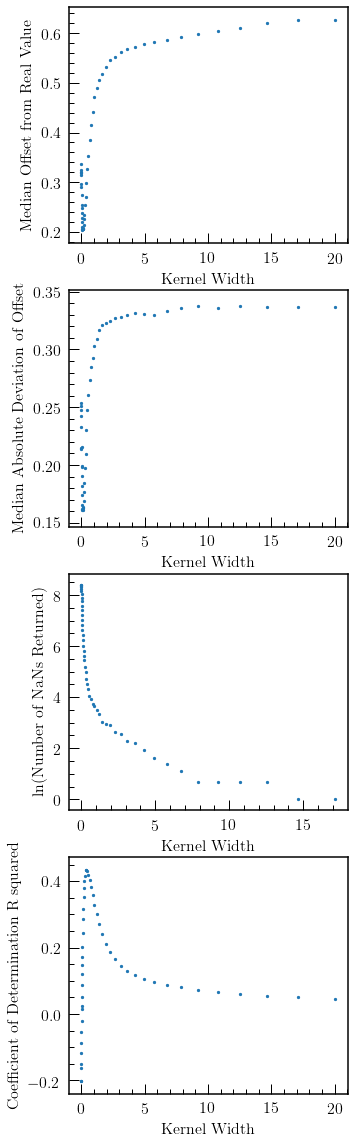

In [10]:
plt.figure(figsize=(5,20))
plt.subplot(411)
plt.scatter(KernelWidth, MedianDiffs, s=5)
plt.xlabel('Kernel Width')
plt.ylabel('Median Offset from Real Value')
#plt.xlim(0,20)
plt.subplot(412)
plt.scatter(KernelWidth, MedianDevia, s=5)
plt.xlabel('Kernel Width')
plt.ylabel('Median Absolute Deviation of Offset')
#plt.xlim(0,20)
plt.subplot(413)
plt.scatter(KernelWidth, np.log(NumNans), s=5)
plt.xlabel('Kernel Width')
plt.ylabel('ln(Number of NaNs Returned)')
#plt.xlim(0,20)
plt.subplot(414)
plt.scatter(KernelWidth, ScoreArray, s=5)
plt.xlabel('Kernel Width')
plt.ylabel('Coefficient of Determination R squared')

Above plots show the change in the NW predictions as kernel width increases.  The top panel shows the median of the difference between our prediction and the real values.  The second panel shows the median absolute deviation of the difference.  The third panel shows the natural log of the number of NaNs returned by the NW algorithm.  I'm only using the log because the number returned for widths < 1 is so much larger than the number returned for widths > 1, multiple orders of 10 larger.  The plateaus are due to number of NaNs being explicitly an integer.  Also note that the last point(kernel width = 20) does not display because there were no NaNs returned and ln(0) is undefined.  The bottom panel shows a score based off of Sci-kit learn's score method, the coefficient of determination R-squared.

In [11]:
for i in range(len(MedianDevia)):
    if MedianDevia[i] == min(MedianDevia):
        print NumNans[i]
        print KernelWidth[i-1], KernelWidth[i], KernelWidth[i+1]
        MinWidth = KernelWidth[i]
for i in range(len(MedianDiffs)):
    if MedianDiffs[i] == min(MedianDiffs):
        print NumNans[i]
        print KernelWidth[i-1], KernelWidth[i], KernelWidth[i+1]
for i in range(len(ScoreArray)):
    if ScoreArray[i] == max(ScoreArray):
        print NumNans[i]
        print ScoreArray[i]
print MinWidth

615.0
0.08773066621237419 0.10245175126239794 0.11964301412374057
615.0
0.08773066621237419 0.10245175126239794 0.11964301412374057
112.0
0.43448043835214045
0.10245175126239794


In [12]:
#In the first loop I want to assign y_pred to y_pred_best, after the first loop I only want to assign Non-NaN entries in y_pred
FirstLoop=True
#loop through descending kernel widths, from 20 to the width with minimum median offset
for i in np.flip(np.logspace(np.log(MinWidth), np.log(20), 50, base=np.exp(1)), 0):
    del model
    model = NadarayaWatson('gaussian', i) #NW model with gaussian kernel of width i
    y_pred, y_test = testingfunc(model, data, returnScore=False) #fit and predict model
    if FirstLoop == True:
        y_pred_best = y_pred #assign predictions to best prediction array
        FirstLoop = False #toggle switch for first loop
    else:
        #loop through and check each new prediction for NaN's, assigning all non-NaN's to best prediction array
        for j in range(len(y_pred)): 
            if (not np.isnan(y_pred[j])):
                y_pred_best[j] = y_pred[j]
print y_pred_best
    

[1.5776644  0.63901734 2.8739543  ... 0.86626756 3.0509384  2.0341687 ]


(0, 6.5)

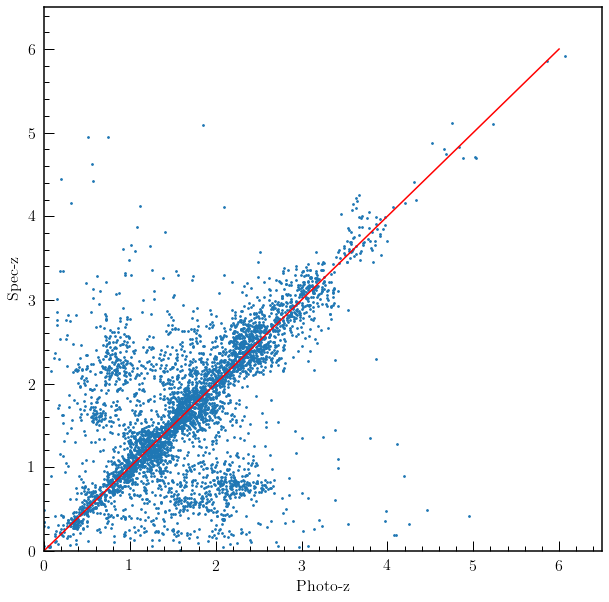

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(y_pred_best, y_test, s=3)
plt.xlabel('Photo-z')
plt.ylabel('Spec-z')
plt.plot([0,1,2,3,4,5,6], color='red')
plt.xlim(0,6.5)
plt.ylim(0,6.5)

Above plot shows the photo-z predictions from our NW method compared to the spectroscopic redshift of the objects.  The photo-z shown is the prediction made at the lowest kernel width for which the prediction was not a NaN.  The objects used were 22687 stripe 82 quasars and the NW is trained on u, g, r, i, and z photometries

In [18]:
print NWscore(y_test,y_pred_best)

(0.19622468948364258, 0.15464037656784058, 0, 0.2370696813621993)
